# Construction and training of a fully connected neural network for recognition of a large set of fonts

### DATASET PREPARING

##### Check available fonts in directory "all-fonts"

In [ ]:
import os
import pandas as pd

def list_files_in_folder(folder_path):
    files_data = []

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        if (os.path.isfile(file_path)):
            file_size = os.path.getsize(file_path) / (1024 * 1024)
            files_data.append({"filename": file_name, "size": file_size})

    df = pd.DataFrame(files_data)

    df_sorted = df.sort_values(by="size", ascending=False).reset_index(drop=True)

    return df_sorted

In [ ]:
files = list_files_in_folder("./all-fonts")
files

##### Creating font paths for all fonts

In [ ]:
font_names = files["filename"].tolist()
font_paths = ["./all-fonts/" + font_name for font_name in font_names]
font_paths

##### Create dataset for training, validation and testing

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

def create_train_val_test_datasets(font_paths):
    train_dataset = pd.DataFrame()
    val_dataset = pd.DataFrame()
    test_dataset = pd.DataFrame()

    columns_to_drop = [
        'fontVariant',
        'm_label',
        'strength',
        'italic',
        'orientation',
        'm_top',
        'm_left',
        'originalH',
        'originalW',
        'h',
        'w'
    ]

    for font_path in font_paths:
        print(f"Splitting {font_path} into Train-Val-Test datasets...")
        
        dataset = pd.read_csv(font_path)
        dataset = dataset.drop(columns=columns_to_drop, errors='ignore')

        train_temp, test_split = train_test_split(dataset, test_size=0.2)

        train_split, val_split = train_test_split(train_temp, test_size=0.25)

        train_dataset = pd.concat([train_dataset, train_split], ignore_index=True)
        val_dataset = pd.concat([val_dataset, val_split], ignore_index=True)
        test_dataset = pd.concat([test_dataset, test_split], ignore_index=True)

    return train_dataset, val_dataset, test_dataset

In [ ]:
train, val, test = create_train_val_test_datasets(font_paths)

In [ ]:
train

In [ ]:
val

In [ ]:
test

##### Export dataset

In [ ]:
train.to_csv("./large-dataset/train.csv", index=False)
val.to_csv("./large-dataset/val.csv", index=False)
test.to_csv("./large-dataset/test.csv", index=False)

### MODEL TRAINING

##### Import dataset and preprocess data

In [53]:
import pandas as pd
import numpy as np
import scipy.ndimage
from tensorflow.keras.utils import to_categorical

def preprocess_data(train_path, val_path, test_path):
    train_dataset = pd.read_csv(train_path)
    val_dataset = pd.read_csv(val_path)
    test_dataset = pd.read_csv(test_path)

    # train_dataset = train_dataset[train_dataset['font'] != 'SEGOE']
    # val_dataset = val_dataset[val_dataset['font'] != 'SEGOE']
    # test_dataset = test_dataset[test_dataset['font'] != 'SEGOE']
    
    X_train = train_dataset.drop('font', axis=1).astype('float32').values
    y_train = train_dataset['font'].values

    X_val = train_dataset.drop('font', axis=1).astype('float32').values
    y_val = train_dataset['font'].values

    X_test = train_dataset.drop('font', axis=1).astype('float32').values
    y_test = train_dataset['font'].values

    unique_labels = np.unique(y_train)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    y_train_encoded = np.array([label_to_index[label] for label in y_train])
    y_val_encoded = np.array([label_to_index[label] for label in y_val])
    y_test_encoded = np.array([label_to_index[label] for label in y_test])

    num_classes = len(unique_labels)

    y_train = to_categorical(y_train_encoded, num_classes=num_classes)
    y_val = to_categorical(y_val_encoded, num_classes=num_classes)
    y_test = to_categorical(y_test_encoded, num_classes=num_classes)

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes, unique_labels

In [54]:
train_path = "https://github.com/PavelKilko/applied-application-of-neural-networks/raw/refs/heads/master/lab-6-7/large-dataset/train.csv"
val_path = "https://github.com/PavelKilko/applied-application-of-neural-networks/raw/refs/heads/master/lab-6-7/large-dataset/val.csv"
test_path = "https://github.com/PavelKilko/applied-application-of-neural-networks/raw/refs/heads/master/lab-6-7/large-dataset/test.csv"

In [55]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes, unique_labels = preprocess_data(train_path, val_path, test_path)

##### Train and test model

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import pandas as pd

In [58]:
def build_and_train_model_v0_4(X_train, y_train, X_val, y_val, X_test, y_test, num_classes):
    model = Sequential()

    model.add(Dense(2048, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.3))

    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.3))

    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.3))

    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    history = model.fit(
        X_train, y_train,
        epochs=200,
        validation_data=(X_val, y_val),
        batch_size=128,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    return model, history, test_loss, test_acc

Training 2048-1024-512-256 model...
Epoch 1/200
3903/3903 [==============================] - 36s 9ms/step - loss: 12.5370 - accuracy: 0.0969 - val_loss: 5.3654 - val_accuracy: 0.3261
Epoch 2/200
3903/3903 [==============================] - 35s 9ms/step - loss: 5.1242 - accuracy: 0.2996 - val_loss: 3.9266 - val_accuracy: 0.4011
Epoch 3/200
3903/3903 [==============================] - 35s 9ms/step - loss: 3.7782 - accuracy: 0.3790 - val_loss: 2.9782 - val_accuracy: 0.4459
Epoch 4/200
3903/3903 [==============================] - 35s 9ms/step - loss: 3.0225 - accuracy: 0.4228 - val_loss: 2.5506 - val_accuracy: 0.4831
Epoch 5/200
3903/3903 [==============================] - 35s 9ms/step - loss: 2.6846 - accuracy: 0.4550 - val_loss: 2.2957 - val_accuracy: 0.5134
Epoch 6/200
3903/3903 [==============================] - 35s 9ms/step - loss: 2.4830 - accuracy: 0.4793 - val_loss: 2.1413 - val_accuracy: 0.5377
Epoch 7/200
3903/3903 [==============================] - 35s 9ms/step - loss: 2.3412 - 

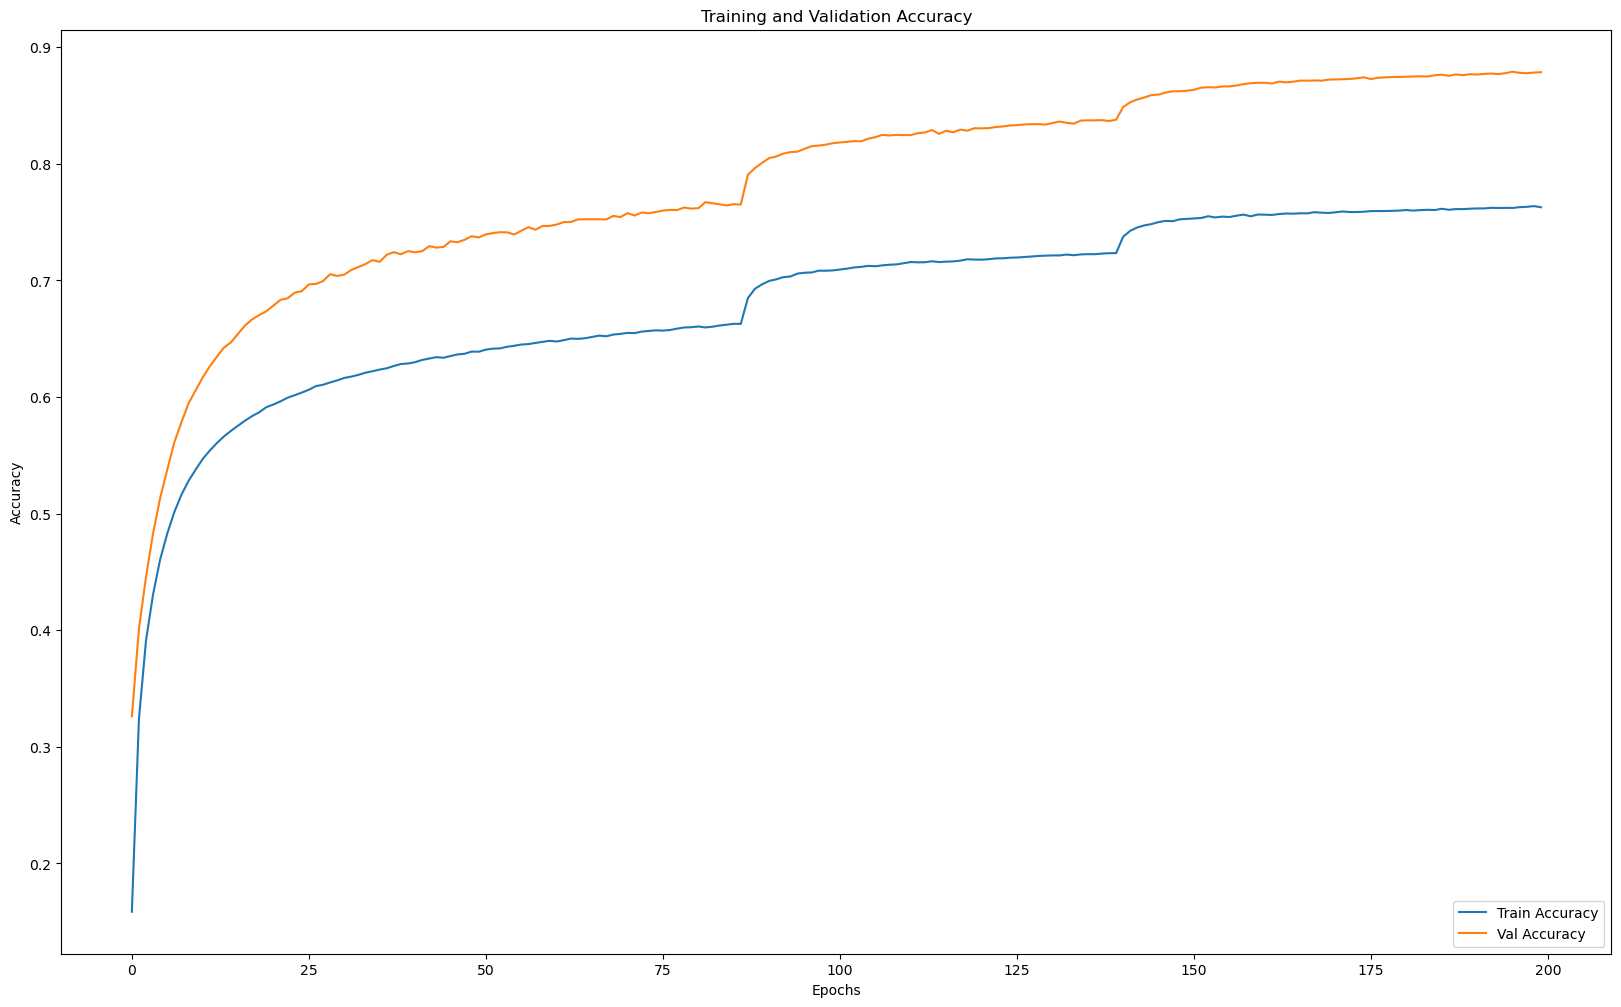

,Test Accuracy,Test Loss
0,0.878634,0.650716


In [59]:
results = []

plt.figure(figsize=(20, 12))

print(f"Training 2048-1024-512-256 model...")

model_v0_4, history, test_loss, test_acc = build_and_train_model_v0_4(X_train, y_train, X_val, y_val, X_test, y_test, num_classes)

results.append({"Test Accuracy": test_acc, "Test Loss": test_loss})

plt.plot(history.history['accuracy'], label=f'Train Accuracy')
plt.plot(history.history['val_accuracy'], label=f'Val Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

results_df = pd.DataFrame(results)

results_df

### Build confusion matrix for final model

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def create_confusion_matrix(model, X_test, y_test):
# Convert one-hot encoded y_test back to class labels
    y_true = np.argmax(y_test, axis=1)

    # Make predictions using the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Convert to percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    return cm_percentage

In [61]:
cm = create_confusion_matrix(model=model_v0_4, X_test=X_test, y_test=y_test)

In [62]:
def display_confusion_matrix(cm, class_names=None, figsize=(64, 64)):
    plt.figure(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='.0f', ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.xticks(rotation=90)
    plt.show()

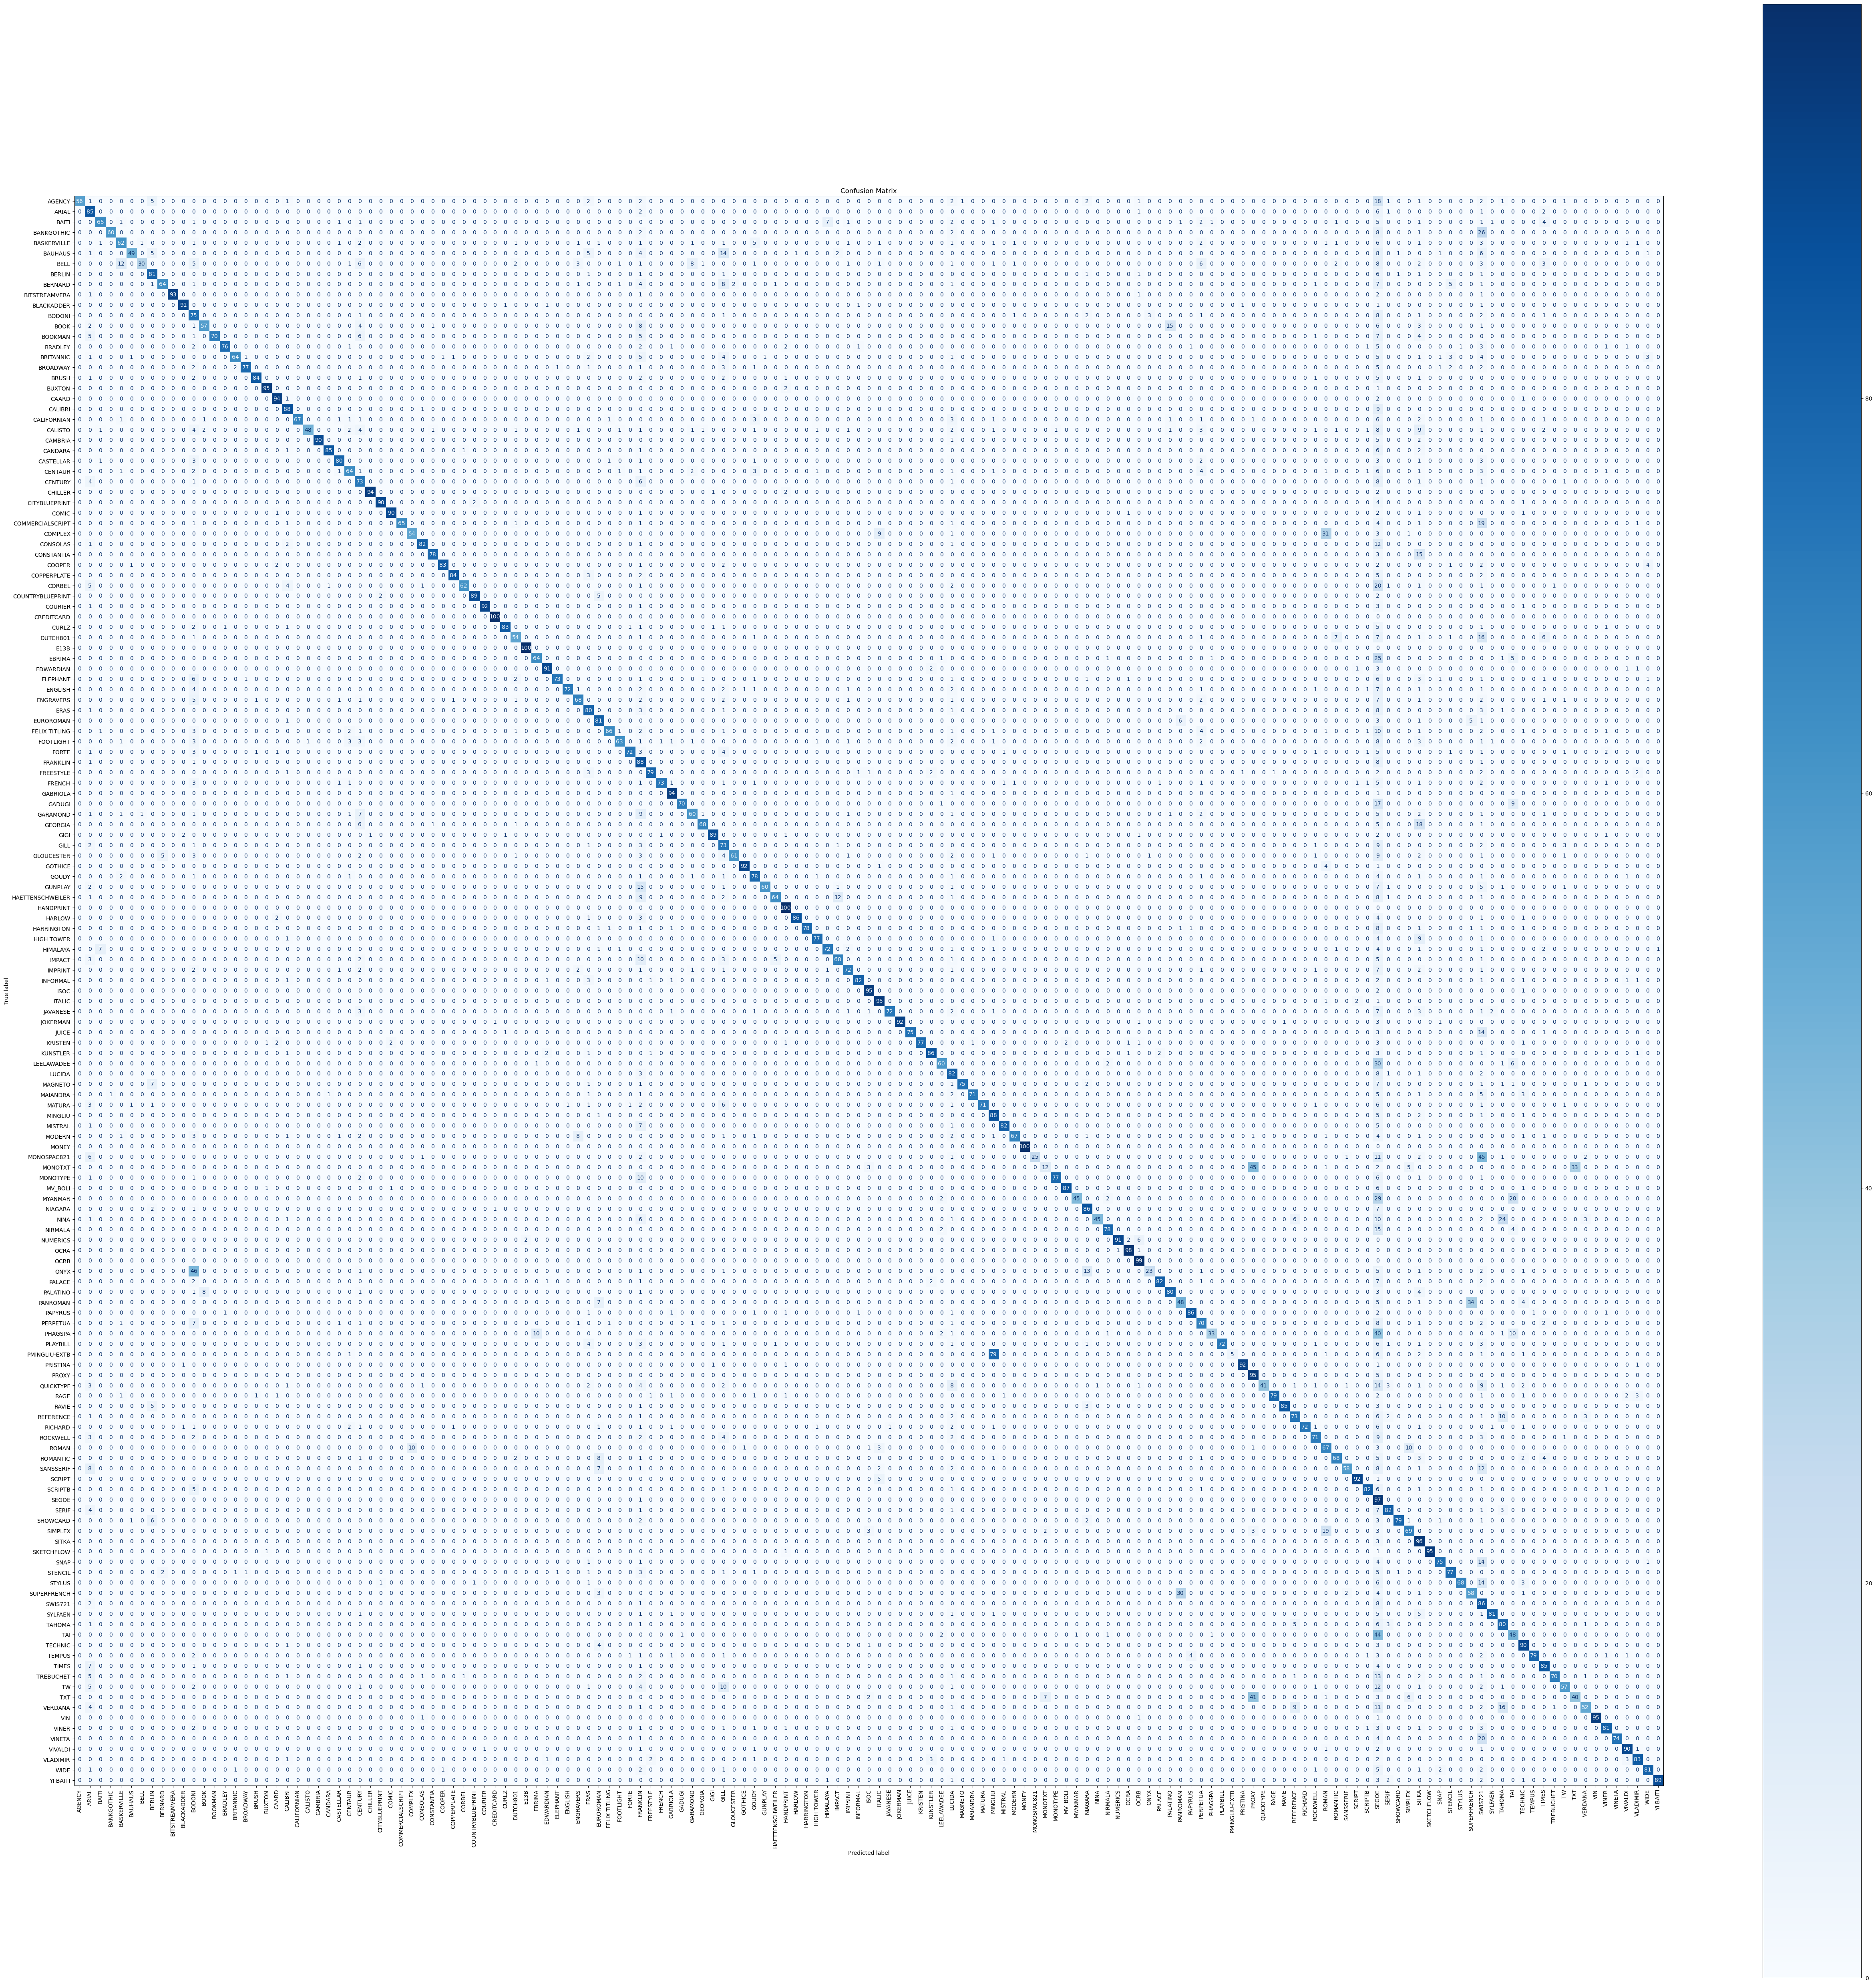

In [63]:
display_confusion_matrix(cm, class_names=unique_labels)

In [64]:
def save_confusion_matrix(cm, class_names=None, figsize=(64, 64), filename="image.png"):
    plt.figure(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='.0f', ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.xticks(rotation=90)
    plt.savefig(filename, dpi=300)
    plt.close()

In [65]:
save_confusion_matrix(cm, class_names=unique_labels, filename="cm-v-0-4.png") 

##### Export final model in file

In [66]:
model_v0_4.save("./models/large-font-recognizer-v0.4.h5")